In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [2]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session (if subsession=True),
    #saves each accordingly
    
    path_split = file_path_name.split('/')
    file_split = path_split[-1].split('_')

    for row in file_split:

        if re.search(r'^\d\d\d\d\d\d$', row):
            date = row
        if re.search(r'^\d\d\d$', row):
            animal_number = row
        if re.search(r'^\d$', row):
            session_num = row 
        
    try:
        session = str(file_split[0] + '_' + session_num)
    except: 
        session = file_split[0]

    return date, animal_number, session, session_num

In [3]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, letter_1, letter_2, order):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    #order is whether the event or time stamp is letter_1 or letter_2
    
    import re
    import numpy as np
    import pandas as pd

    i = 0
    letter_1_array = []
    letter_2_array = []

    while i < len(array):
        if re.search(str(letter_1 + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    letter_1_array.append(float(element))
                i = i + 1
        if re.search(str(letter_2 + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    letter_2_array.append(float(element))
                i = i + 1
        i = i + 1
    
    if order == 'event':
        eandt = np.column_stack((letter_1_array, letter_2_array))
        es_et = pd.DataFrame(data = eandt)
        es_et.columns = ['event_stamp', 'time_stamp']
        
    if order == 'time':
        eandt = np.column_stack((letter_2_array, letter_1_array))
        es_et = pd.DataFrame(data = eandt)
        es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [16]:
def get_trial_times_PR(events_and_times, right_extends, left_extends, ITI_start, ITI_end, session_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for start and end of trial segment
    #e.g. conditioned stimulus onset and offset, ITI onset and offset - here both levers extend so can just use right lever as start
    #finds time_stamps for each start and end, puts into new dataframe
    import numpy as np
    import pandas as pd

    start_time = events_and_times[(events_and_times.event_stamp == right_extends)]['time_stamp'].values
    end_time = events_and_times[(events_and_times.event_stamp == ITI_start) | (events_and_times.event_stamp == session_end)]['time_stamp'].values
    start_time_ITI = events_and_times[events_and_times.event_stamp == ITI_start]['time_stamp'].values
    end_time_ITI = events_and_times[events_and_times.event_stamp == ITI_end]['time_stamp'].values
    
    times = pd.DataFrame(data = [start_time, end_time, start_time_ITI, end_time_ITI])
    times = times.T
    times.columns = ['trial_start', 'trial_end', 'ITI_start', 'ITI_end']
    
    return times

In [6]:
def create_trial_df(events_and_times, trial_times, trial_type):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    if trial_type == 'ITI':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['ITI_start'][i]) & (events_and_times['time_stamp'] <= trial_times['ITI_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['ITI_start'] = trial_times['ITI_start'][i]
            data['ITI_end'] = trial_times['ITI_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'within':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['trial_start'] = trial_times['trial_start'][i]
            data['trial_end'] = trial_times['trial_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    
    return trial_data

In [7]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [8]:
def latency(trial_data, event_num, trial_type):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_ave.append(np.nan)
        else:
            if trial_type == 'ITI':
                latency_1st.append((data['time_stamp'] - data['ITI_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['ITI_start']).values.mean()/100)
            elif trial_type == 'within':
                latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean()/100)
        i = i + 1
    
    return latency_1st, latency_ave

In [9]:
def create_session_df(trial_data, event_dic, trial_type):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    if trial_type == 'ITI':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['ITI_start'].unique(), trial_data.groupby('trial_#')['ITI_end'].unique()])
        times_df = times_df.T
    elif trial_type == 'within':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
        times_df = times_df.T  
        
    i = 0
    trial_times = []
    while i < times_df.shape[0]:
        if trial_type == 'ITI':
            trial_time = (times_df.iloc[i]['ITI_end'] - times_df.iloc[i]['ITI_start'])/100
        elif trial_type == 'within':
            trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave')] = latency(trial_data, event, trial_type)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

### Variable Definitions

- A   = active lever (1 = Left, any other number = Right)
- B   = number of right nose pokes
- C   = number of left nose pokes
#### D   = event time stamp
#### E   = event identity stamp

### Event Stamps

####      46 - Right lever extends 
- trial starts

####      47 - Left lever extends
- trial starts

####      12 - Intertrial interval begins
####      13 - Intertrial interval over and reinforcement available again

####      10 - ITI Right lever press
####      11 - ITI Left lever press
####      14 - ITI Head entry

####      40 - PR reset lever pressed (right)
####      41 - PR reset lever pressed (left)
####      3  - Non-ITI Left lever press
####       4  - Non-ITI Right lever press
####      7  - Non-ITI Head entry
####      17 - Pellet delivery

-      5  - Reinforced left lever press
-      6  - Reinforced right lever press
-      8  - Non-ITI Right nose poke
-      9  - Non-ITI Left nose poke
-      15 - ITI Right nose-poke
-      16 - ITI Left nose-poke
-      18 - Tone delivery
-      42 - Right cue light active
-      43 - Left cue light active
-      44 - Right cue light off
-      45 - Left cue light off
-      48 - Right lever retracts
-      49 - Left lever retracts
-      50 - Head entry to initiate trial
-     100 - End of session marker

In [10]:
path_1 = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR'

session_list_1 = os.listdir(path_1)
print(len(session_list_1))
session_list_1[0:5]

34


['PR13_1_825_200228',
 'PR13_1_826_200228',
 'PR13_1_827_200228',
 'PR13_1_828_200228',
 'PR13_1_829_200228']

In [13]:
file_paths = []
for file in session_list_1:
    file_path = path_1 + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

34


'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_825_200228'

In [14]:
#read animal info (lever assignment, group etc) into df

path_animal_info = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/PR_r2_2020Feb.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

animal_info.head()

,cage,animal,group,lever
0,158,825,1,0
1,158,826,1,0
2,158,827,1,0
3,159,828,1,1
4,159,829,1,1


In [17]:
%%time
final_data = pd.DataFrame()

bit_dic = {'reinforcement': 17, 'right_lever': 4, 'left_lever': 3, 'HE': 7}
ITI_dic = {'reinforcement': 17, 'right_lever': 10, 'left_lever': 11, 'HE': 14}

for file in file_paths:

    print(file) 
    
    #proccess file
    date, animal_number, session, session_num = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "D", "E", 'time')
    trial_times = get_trial_times_PR(events_and_times, 46, 47, 12, 13, 100)
    trial_data = create_trial_df(events_and_times, trial_times, 'within')
    ITItrial_data = create_trial_df(events_and_times, trial_times, 'ITI')
    session_data = create_session_df(trial_data, bit_dic, 'within')
    ITIsession_data = create_session_df(ITItrial_data, ITI_dic, 'ITI')
   
    #create pandas tidy df for within session
    session_data['type'] = ['session']*(session_data.shape[0])    
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal_number'] = [animal_number]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['session_num'] = [session_num]*(session_data.shape[0])
    session_data['active_lever'] = int(animal_info[animal_info['animal'] == int(animal_number)]['lever'])
    session_data['group'] = int(animal_info[animal_info['animal'] == int(animal_number)]['group'])
    session_data['cage'] = int(animal_info[animal_info['animal'] == int(animal_number)]['cage'])
   
    session_data = session_data[['type', 'date', 'session', 'session_num', 'cage', 'animal_number', 'group', 'active_lever', 
                                 'trial_num', 'trial_duration', 'reinforcement_count', 'reinforcement_latency_1st', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'reinforcement_latency_ave', 'right_lever_latency_ave', 'left_lever_latency_ave']]
    
    #create pandas tidy df for within ITI
    ITIsession_data['type'] = ['ITI']*(ITIsession_data.shape[0])  
    ITIsession_data['date'] = [date]*(ITIsession_data.shape[0])
    ITIsession_data['animal_number'] = [animal_number]*(ITIsession_data.shape[0])
    ITIsession_data['session'] = [session]*(ITIsession_data.shape[0])
    ITIsession_data['session_num'] = [session_num]*(ITIsession_data.shape[0])
    ITIsession_data['active_lever'] = int(animal_info[animal_info['animal'] == int(animal_number)]['lever'])
    ITIsession_data['group'] = int(animal_info[animal_info['animal'] == int(animal_number)]['group'])
    ITIsession_data['cage'] = int(animal_info[animal_info['animal'] == int(animal_number)]['cage'])
    
    ITIsession_data = ITIsession_data[['type', 'date', 'session', 'session_num', 'cage', 'animal_number', 'group', 'active_lever', 
                                 'trial_num', 'trial_duration', 'reinforcement_count', 'reinforcement_latency_1st', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'reinforcement_latency_ave', 'right_lever_latency_ave', 'left_lever_latency_ave']]

    #add to final data frame
    final_data = pd.concat([final_data, session_data, ITIsession_data], axis = 0, ignore_index=True)

final_data.head()

C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_825_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_826_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_827_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_828_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_829_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_830_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_831_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/PR13_1_832_200228
C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/progressive_ratio/round2/PR/P

,type,date,session,session_num,cage,animal_number,group,active_lever,trial_num,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_count,HE_latency_1st,HE_latency_ave,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,reinforcement_latency_ave,right_lever_latency_ave,left_lever_latency_ave
0,session,200228,PR13_1,1,158,825,1,0,0,8.06,1,8.06,0,NaN,NaN,1,8.05,0,NaN,8.06,8.050000,NaN
1,session,200228,PR13_1,1,158,825,1,0,1,41.18,1,41.18,2,10.74,11.335,2,40.65,0,NaN,41.18,40.910000,NaN
2,session,200228,PR13_1,1,158,825,1,0,2,63.11,1,63.11,3,39.99,41.680,2,62.58,0,NaN,63.11,62.840000,NaN
3,session,200228,PR13_1,1,158,825,1,0,3,51.51,1,51.51,1,15.94,15.940,3,50.07,0,NaN,51.51,50.846667,NaN
4,session,200228,PR13_1,1,158,825,1,0,4,19.00,1,19.00,0,NaN,NaN,4,16.08,0,NaN,19.00,17.445000,NaN


In [22]:
#make new df with combined data
df_final = final_data.copy()

lp_train_df_trial = pd.DataFrame()

animals = df_final['animal_number'].unique()

for animal in animals:
    
    #get animal data
    animal_data = df_final[df_final['animal_number'] == animal]
    
    #generate session df
    sessions = animal_data['session'].unique()
    
    for session in sessions:
        #get session data for animal
        animal_data_session = animal_data[animal_data['session'] == session]
        
        #compute and fill session data
        if animal_data_session['active_lever'].unique() == 0:
            animal_data_session['active_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']

        elif animal_data_session['active_lever'].unique() == 1:
            animal_data_session['active_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            
        lp_train_df_trial = lp_train_df_trial.append(animal_data_session)
        
lp_train_df_trial.reset_index(inplace=True, drop=True)    

lp_train_df_trial = lp_train_df_trial[['type', 'date', 'session', 'session_num', 'cage', 'animal_number', 'group',
                                       'active_lever', 'trial_num', 'trial_duration',
                                       'reinforcement_count', 'reinforcement_latency_1st',
                                       'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                       'active_lever_count', 'active_lever_latency_1st',
                                       'inactive_lever_count', 'inactive_lever_latency_1st', 
                                       'active_lever_latency_ave', 'inactive_lever_latency_ave', 'reinforcement_latency_ave']]

lp_train_df_trial['lever_ratio'] = lp_train_df_trial['active_lever_count'] / (lp_train_df_trial['active_lever_count'] + lp_train_df_trial['inactive_lever_count'])

print(lp_train_df_trial.shape)
lp_train_df_trial.head()

(1148, 23)


,type,date,session,session_num,cage,animal_number,group,active_lever,trial_num,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_count,HE_latency_1st,HE_latency_ave,active_lever_count,active_lever_latency_1st,inactive_lever_count,inactive_lever_latency_1st,active_lever_latency_ave,inactive_lever_latency_ave,reinforcement_latency_ave,lever_ratio
0,session,200228,PR13_1,1,158,825,1,0,0,8.06,1,8.06,0,NaN,NaN,1,8.05,0,NaN,8.050000,NaN,8.06,1.0
1,session,200228,PR13_1,1,158,825,1,0,1,41.18,1,41.18,2,10.74,11.335,2,40.65,0,NaN,40.910000,NaN,41.18,1.0
2,session,200228,PR13_1,1,158,825,1,0,2,63.11,1,63.11,3,39.99,41.680,2,62.58,0,NaN,62.840000,NaN,63.11,1.0
3,session,200228,PR13_1,1,158,825,1,0,3,51.51,1,51.51,1,15.94,15.940,3,50.07,0,NaN,50.846667,NaN,51.51,1.0
4,session,200228,PR13_1,1,158,825,1,0,4,19.00,1,19.00,0,NaN,NaN,4,16.08,0,NaN,17.445000,NaN,19.00,1.0


<Figure size 1440x720 with 0 Axes>

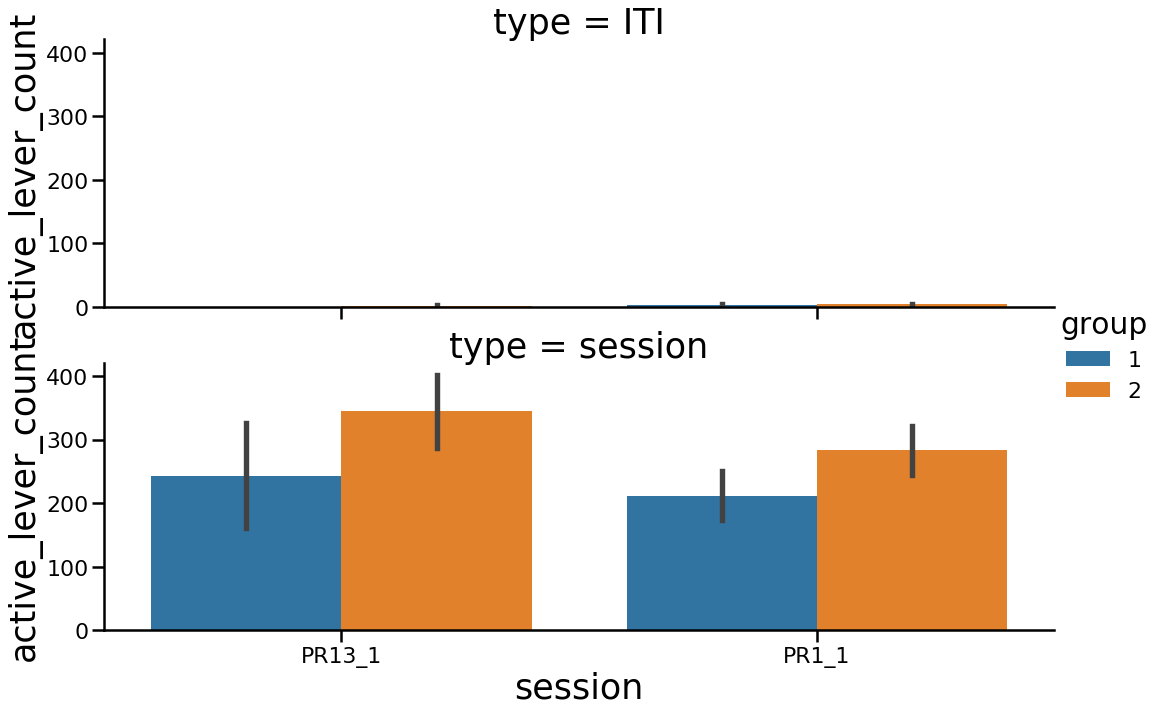

In [31]:
break_pt_df = lp_train_df_trial[lp_train_df_trial['reinforcement_count'] != 0].groupby(['type', 'session', 'group', 'animal_number'])['active_lever_count'].max().reset_index()
plt.figure(figsize=(20,10))
sns.catplot(x='session', y='active_lever_count', hue='group', data=break_pt_df, ci=68, kind='bar', 
            height=5, aspect=3, col='type', col_wrap=1)
plt.show()

<Figure size 1440x720 with 0 Axes>

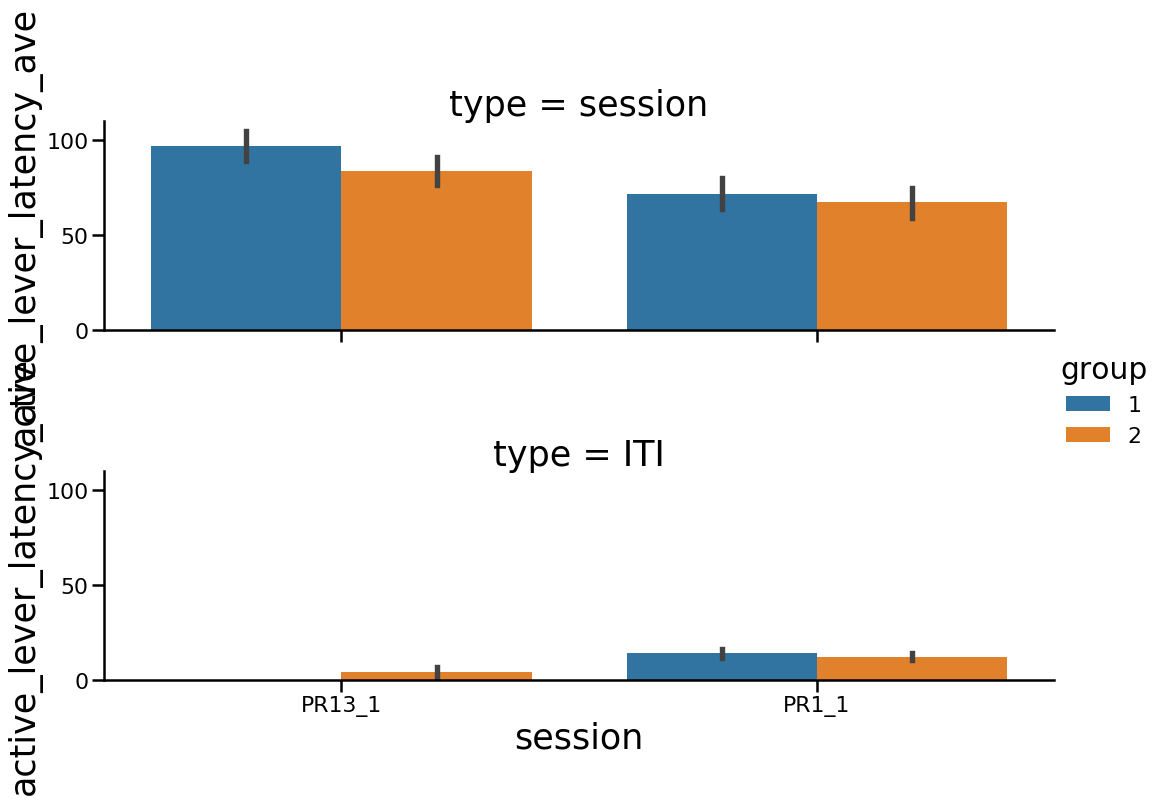

In [36]:
plt.figure(figsize=(20,10))
sns.catplot(x='session', y='active_lever_latency_ave', data=lp_train_df_trial, hue='group', ci=68, kind='bar', 
            height=5, aspect=3, col='type', col_wrap=1)
plt.show()

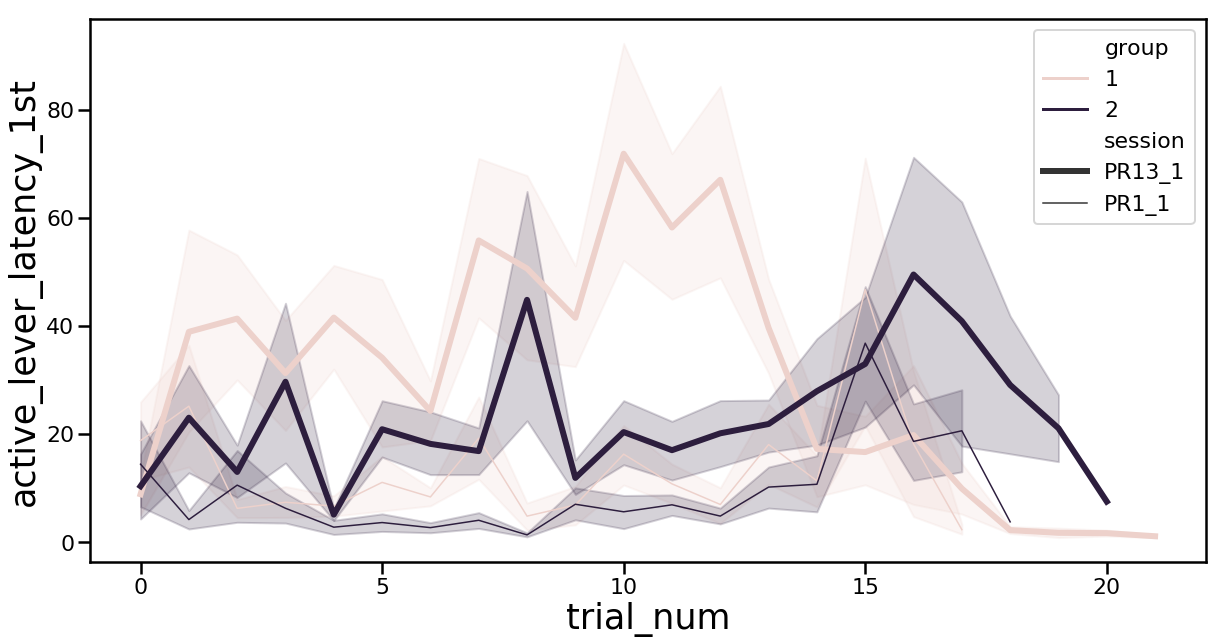

In [35]:
data_session = lp_train_df_trial[lp_train_df_trial['type'] == 'session']
data_ITI = lp_train_df_trial[lp_train_df_trial['type'] == 'ITI']

plt.figure(figsize=(20,10))
sns.lineplot(x='trial_num', y='active_lever_latency_1st', data=data_session[data_session['trial_num'] < 50], hue='group', ci=68, size='session', legend='full')
plt.show()

In [ ]:
sum_df = (lp_train_df_trial.groupby(['type', 'session', 'group', 'animal_number'])['reinforcement_count', 'active_lever_count', 'inactive_lever_count', 'HE_count'].sum()).reset_index()
sum_df['lever_ratio'] = sum_df['active_lever_count'] / (sum_df['active_lever_count'] + sum_df['inactive_lever_count'])
sum_df_unstack = sum_df.set_index(['type', 'animal_number', 'group', 'session']).unstack(-1).reset_index()
sum_df_unstack.to_csv('sum_df_unstack.csv')
sum_df.head()

In [ ]:
sns.catplot(x='session', y='lever_ratio', data=sum_df, hue='group', ci=68, kind='bar', 
            height=5, aspect=3, col='type', col_wrap=1)
plt.show()

In [ ]:
ave_df = (lp_train_df_trial.groupby(['type', 'session', 'group', 'animal_number'])['trial_duration',
                                                                                   'reinforcement_latency_1st',
                                                                                   'HE_latency_1st', 'HE_latency_ave', 
                                                                                   'active_lever_latency_1st', 'inactive_lever_latency_1st', 
                                                                                   'active_lever_latency_ave','inactive_lever_latency_ave', 
                                                                                   'reinforcement_latency_ave'].mean()).reset_index()
ave_df_unstack = ave_df.set_index(['type', 'animal_number', 'group', 'session']).unstack(-1).reset_index()
ave_df_unstack.to_csv('ave_df_unstack.csv')
ave_df.head()

In [ ]:
file_path = file_paths[0]
print('file_path:', '\n', file_path, '\n')

date, animal_number, session, session_num = get_file_info(file_path)
print('date:', date, 'animal_number:', animal_number, 'session:', session, 'session_num:', session_num, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "D", "E", 'time')
print(events_and_times.head(), '\n')

trial_times = get_trial_times_PR(events_and_times, 46,47,12,13)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times, 'within')
print(trial_data.head(), '\n')

ITI_data = create_trial_df(events_and_times, trial_times, 'ITI')
print(ITI_data.head(), '\n')

bit_dic = {'reinforcement': 17, 'right_lever_choice': 4, 'left_lever_choice': 3, 'HE_trial': 7}
session_data = create_session_df(trial_data, bit_dic, 'within')

ITI_dic = {'right_lever_choice': 10, 'left_lever_choice': 11, 'HE_trial': 14}
ITI_data = create_session_df(ITI_data, ITI_dic, 'ITI')